In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [11]:
df = pd.read_csv('insider_trades_with_returns.csv')

In [ ]:
# Optional imports with graceful fallback
try:
    from lightgbm import LGBMRegressor
except ImportError:
    LGBMRegressor = None
    print("[warn] lightgbm not installed; skipping LGBMRegressor")

try:
    from catboost import CatBoostClassifier
except ImportError:
    CatBoostClassifier = None
    print("[warn] catboost not installed; skipping CatBoostClassifier")


In [12]:
# Exclude rows where return_30d_close, return_60d_close, or return_90d_close are NaN
# Keep only needed columns afterward (avoid overwriting the filtered frame)
df_clean = df.dropna(subset=['return_30d_close', 'return_60d_close', 'return_90d_close']).copy()
df_clean = df_clean.drop(columns=['transaction_date', 'trade_date', 'company_name'], errors='ignore')

In [13]:
# Function to clean numeric strings (remove $, +, commas, parentheses)
def clean_numeric(series):
    """Remove $, +, commas, and convert to float"""
    return series.astype(str).str.replace('$', '', regex=False)\
                              .str.replace('+', '', regex=False)\
                              .str.replace(',', '', regex=False)\
                              .str.replace('(', '-', regex=False)\
                              .str.replace(')', '', regex=False)\
                              .str.strip()

# Convert string columns
df_clean['ticker'] = df_clean['ticker'].astype(str)
df_clean['owner_name'] = df_clean['owner_name'].astype(str)
df_clean['Title'] = df_clean['Title'].astype(str)
df_clean['transaction_type'] = df_clean['transaction_type'].astype(str)

# Convert last_price (remove $ and convert to float)
df_clean['last_price'] = pd.to_numeric(clean_numeric(df_clean['last_price']), errors='coerce')

# Convert Qty (remove + and commas, convert to float)
df_clean['Qty'] = pd.to_numeric(clean_numeric(df_clean['Qty']), errors='coerce')

# Convert shares_held (remove commas, convert to float)
df_clean['shares_held'] = pd.to_numeric(clean_numeric(df_clean['shares_held']), errors='coerce')

# Convert Owned (remove % if present, convert to float)
df_clean['Owned'] = pd.to_numeric(df_clean['Owned'].astype(str).str.replace('%', '', regex=False), errors='coerce') / 100

# Convert Value (remove $, +, commas, convert to float)
df_clean['Value'] = pd.to_numeric(clean_numeric(df_clean['Value']), errors='coerce')



In [14]:
df_clean

,ticker,owner_name,Title,transaction_type,last_price,Qty,shares_held,Owned,Value,return_30d_close,return_60d_close,return_90d_close
0,AGCO,Srinivasan Mallika,Dir,P - Purchase,50.21,465590,5294097,0.10,23378427,0.079912,0.105421,0.002391
1,MRC,Crampton Christopher A.S.,Dir,P - Purchase,32.58,6049,29088257,0.00,197063,-0.110841,-0.005770,-0.152141
2,ENBP,Weaver Judith A,Dir,P - Purchase,28.75,175,1437,0.14,5031,0.008696,0.041739,0.022261
4,FAST,Ancius Michael J,Dir,P - Purchase,48.30,428,6264,0.07,20670,0.081756,-0.007905,-0.019555
5,UFCS,Lyons Dianne M,"VP, CFO",P - Purchase,25.39,8,14359,0.00,203,0.130349,0.105222,-0.063604
...,...,...,...,...,...,...,...,...,...,...,...,...
189478,MPB,Evans Albert J.,Dir,P - Purchase,29.50,8474,36919,0.30,249983,0.050475,-0.054736,0.011472
189479,SCWO,Vanderhider James Michael,Dir,P - Purchase,1.25,250000,1460000,0.21,312500,-0.291262,-0.427184,-0.650485
189480,AGCO,De Lange Bob,Dir,P - Purchase,91.80,2740,11176,0.32,251532,0.051993,0.051668,0.055893
189481,PFBX,Swetman Chevis,"CEO, Pres",P - Purchase,17.75,16883,414049,0.04,299673,0.000556,0.033333,0.061667


In [15]:
df_clean = df_clean.dropna(subset=['return_30d_close', 'return_60d_close', 'return_90d_close'])
df_clean

,ticker,owner_name,Title,transaction_type,last_price,Qty,shares_held,Owned,Value,return_30d_close,return_60d_close,return_90d_close
0,AGCO,Srinivasan Mallika,Dir,P - Purchase,50.21,465590,5294097,0.10,23378427,0.079912,0.105421,0.002391
1,MRC,Crampton Christopher A.S.,Dir,P - Purchase,32.58,6049,29088257,0.00,197063,-0.110841,-0.005770,-0.152141
2,ENBP,Weaver Judith A,Dir,P - Purchase,28.75,175,1437,0.14,5031,0.008696,0.041739,0.022261
4,FAST,Ancius Michael J,Dir,P - Purchase,48.30,428,6264,0.07,20670,0.081756,-0.007905,-0.019555
5,UFCS,Lyons Dianne M,"VP, CFO",P - Purchase,25.39,8,14359,0.00,203,0.130349,0.105222,-0.063604
...,...,...,...,...,...,...,...,...,...,...,...,...
189478,MPB,Evans Albert J.,Dir,P - Purchase,29.50,8474,36919,0.30,249983,0.050475,-0.054736,0.011472
189479,SCWO,Vanderhider James Michael,Dir,P - Purchase,1.25,250000,1460000,0.21,312500,-0.291262,-0.427184,-0.650485
189480,AGCO,De Lange Bob,Dir,P - Purchase,91.80,2740,11176,0.32,251532,0.051993,0.051668,0.055893
189481,PFBX,Swetman Chevis,"CEO, Pres",P - Purchase,17.75,16883,414049,0.04,299673,0.000556,0.033333,0.061667


# ONE MONTH

In [16]:
# Hyperparameter tuning for 30d/60d/90d XGBoost models (light search)
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assumes df_model_X, X_train_raw_X, X_test_raw_X, y_train_X, y_test_X etc. exist per horizon,
# with preprocess_splits defined similarly to earlier cells.
# Replace X_train_raw/y_train/y_train_raw variable names accordingly in your notebook.

param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.08],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
}

def tune_xgb(X_train, y_train, weights=None, n_iter=8, random_state=42):
    tscv = TimeSeriesSplit(n_splits=3)
    base = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=random_state,
        reg_alpha=0.1,
        reg_lambda=1.0,
    )
    search = RandomizedSearchCV(
        base,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=tscv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1,
    )
    search.fit(X_train, y_train, sample_weight=weights)
    return search.best_estimator_, search.best_params_, -search.best_score_

# Example for 30d (adapt variable names from your previous cells):
# X_train_30, X_test_30 = preprocess_splits(X_train_raw_30, X_test_raw_30, y_train_30)
# weights_30 = compute_sample_weight(class_weight='balanced', y=X_train_raw_30['transaction_type'])
# model_30, best_params_30, cv_mae_30 = tune_xgb(X_train_30, y_train_30, weights=weights_30)
# y_pred_30 = model_30.predict(X_test_30)
# mae_30 = mean_absolute_error(y_test_30, y_pred_30)
# print(f"30d best params: {best_params_30}, cv_MAE={cv_mae_30:.4f}, test_MAE={mae_30:.4f}")

# Repeat for 60d/90d by swapping the train/test variables.


Transaction Type Distribution:
transaction_type
P - Purchase    120040
S - Sale            70
S - Sale+OE         67
Name: count, dtype: int64

Train size: 96128, Test size: 24033

Preprocessing data (Target Encoding and Scaling)...
Training XGBoost on 8 features...
Cross-validation MAE: 0.1053 (+/- 0.0005)

🚀 === Test Set Performance ===
Mean Squared Error: 0.0399
Root Mean Squared Error (RMSE): 0.1997
Mean Absolute Error (MAE): 0.1112
R² Score: 0.0907

Baseline MAE (predicting mean): 0.1145
Improvement over baseline: 2.91%

=== Performance by Transaction Type ===
P - Purchase        : MAE=0.1112, R²=0.0905, n=24000
S - Sale            : MAE=0.0799, R²=0.2463, n=16
S - Sale+OE         : MAE=0.0742, R²=0.4253, n=17


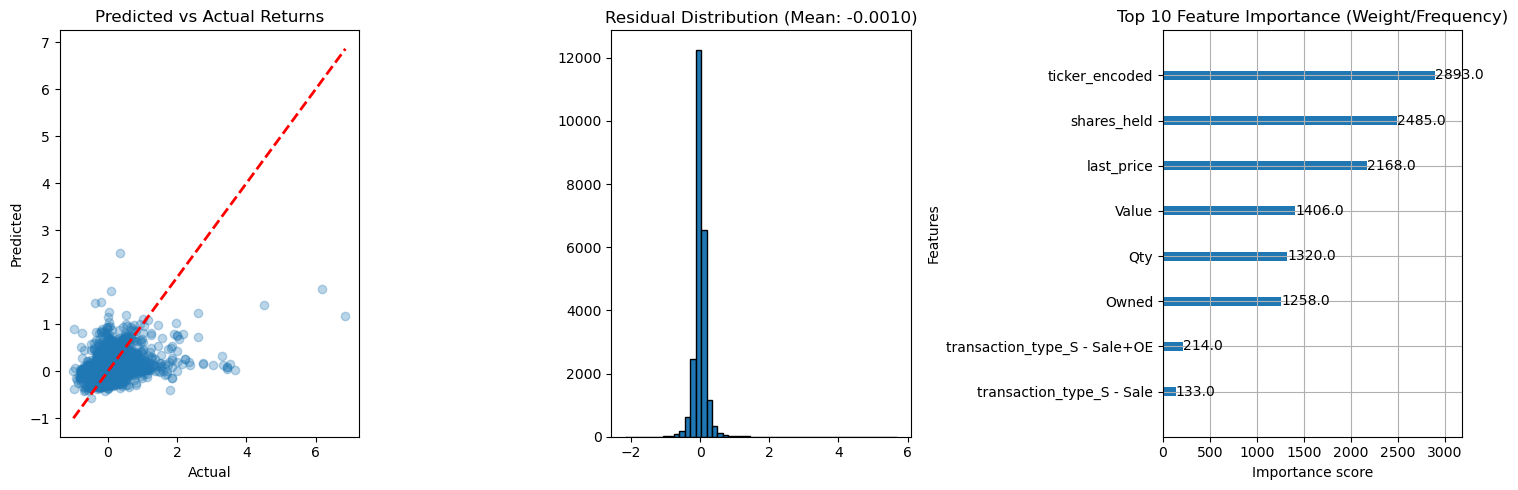


=== Overfitting Check ===
Train MAE: 0.1027
Test MAE: 0.1112
Difference: 0.0085


In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# --- Configuration ---
# NOTE: df_clean must be defined and loaded before running this script.
BASE_NUMERIC_FEATURES = ['last_price', 'Qty', 'shares_held', 'Owned', 'Value']
CATEGORICAL_FEATURES = ['transaction_type', 'ticker']
TARGET_COLUMN = 'return_30d_close'
ALL_FEATURES = BASE_NUMERIC_FEATURES + CATEGORICAL_FEATURES


# ==========================================
# 1. Data Processing Function
# ==========================================
def preprocess_splits(X_train, X_test, y_train):
    """Handles Target Encoding, One-Hot Encoding, and Scaling."""

    X_train = X_train.copy()
    X_test = X_test.copy()

    # --- A. Target Encoding for Ticker ---
    # Calculate mean return per ticker ONLY on training data
    ticker_means = y_train.groupby(X_train['ticker']).mean()
    global_mean = y_train.mean()

    X_train['ticker_encoded'] = X_train['ticker'].map(ticker_means)
    X_test['ticker_encoded'] = X_test['ticker'].map(ticker_means)

    # Fill unknown tickers in test set with the global average
    X_test['ticker_encoded'] = X_test['ticker_encoded'].fillna(global_mean)

    # Drop the original text column
    X_train = X_train.drop(columns=['ticker'])
    X_test = X_test.drop(columns=['ticker'])

    scaled_cols = BASE_NUMERIC_FEATURES + ['ticker_encoded']

    # --- B. One-Hot Encoding for Transaction Type ---
    X_train = pd.get_dummies(X_train, columns=['transaction_type'], drop_first=True)
    X_test = pd.get_dummies(X_test, columns=['transaction_type'], drop_first=True)

    # Ensure test set has same columns as train
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # --- C. Standardization (Scaling) ---
    scaler = StandardScaler()

    # Scale only the designated numeric and encoded columns
    X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])
    X_test[scaled_cols] = scaler.transform(X_test[scaled_cols])

    return X_train, X_test

# ==========================================
# 2. Visualization Function
# ==========================================
def plot_performance(y_test, y_pred, model):
    """Generates evaluation plots including 'weight' feature importance."""

    plt.figure(figsize=(15, 5))

    # Plot 1: Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.3)
    # Plot the ideal prediction line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Predicted vs Actual Returns')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Plot 2: Residual Histogram
    residuals = y_test - y_pred
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=50, edgecolor='black')
    plt.title(f'Residual Distribution (Mean: {residuals.mean():.4f})')

    # Plot 3: Feature Importance (Weight/Frequency)
    plt.subplot(1, 3, 3)

    xgb.plot_importance(
        model,
        max_num_features=10,
        importance_type='weight', # Changed from 'gain' to 'weight'
        ax=plt.gca()
    )
    plt.title("Top 10 Feature Importance (Weight/Frequency)")

    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN EXECUTION FLOW
# ==========================================

# Check transaction type distribution (Original Step 1)
print("Transaction Type Distribution:")
print(df_clean['transaction_type'].value_counts())

# Filter data (Original Step 1)
df_model = df_clean[df_clean[TARGET_COLUMN].abs() <= 10].copy()

# 1. Splitting Data
X = df_model[ALL_FEATURES]
y = df_model[TARGET_COLUMN]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTrain size: {len(X_train_raw)}, Test size: {len(X_test_raw)}")

# 2. Processing Data
print("\nPreprocessing data (Target Encoding and Scaling)...")
X_train, X_test = preprocess_splits(X_train_raw, X_test_raw, y_train)

# 3. Compute Sample Weights (based on raw transaction type)
weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train_raw['transaction_type']
)

# 4. Train Model
print(f"Training XGBoost on {X_train.shape[1]} features...")
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=1.0
)

# Cross-validation on training set
cv_scores = cross_val_score(model, X_train, y_train,
                             cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

model.fit(X_train, y_train, sample_weight=weights)

# 5. Evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n🚀 === Test Set Performance ===")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Baseline comparison
baseline_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
print(f"\nBaseline MAE (predicting mean): {baseline_mae:.4f}")
print(f"Improvement over baseline: {((baseline_mae - mae) / baseline_mae * 100):.2f}%")

# Performance by transaction type (using raw test data)
print("\n=== Performance by Transaction Type ===")
test_transaction_types = X_test_raw['transaction_type'].values
for trans_type in sorted(np.unique(test_transaction_types)):
    mask = test_transaction_types == trans_type
    if mask.sum() > 0:
        mae_type = mean_absolute_error(y_test[mask], y_pred[mask])
        r2_type = r2_score(y_test[mask], y_pred[mask])
        print(f"{trans_type:20s}: MAE={mae_type:.4f}, R²={r2_type:.4f}, n={mask.sum()}")


# 6. Visualize
plot_performance(y_test, y_pred, model)

# 7. Check Overfitting
train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_pred)
print(f"\n=== Overfitting Check ===")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Difference: {abs(train_mae - mae):.4f}")

# TWO MONTH

Transaction Type Distribution:
transaction_type
P - Purchase    120040
S - Sale            70
S - Sale+OE         67
Name: count, dtype: int64

Train size: 96115, Test size: 24029

Preprocessing data (Target Encoding and Scaling)...
Training XGBoost on 8 features...
Cross-validation MAE: 0.1435 (+/- 0.0012)

🚀 === Test Set Performance ===
Mean Squared Error: 0.0826
Root Mean Squared Error (RMSE): 0.2874
Mean Absolute Error (MAE): 0.1531
R² Score: 0.1403

Baseline MAE (predicting mean): 0.1605
Improvement over baseline: 4.59%

=== Performance by Transaction Type ===
P - Purchase        : MAE=0.1532, R²=0.1402, n=23996
S - Sale            : MAE=0.1050, R²=-0.1055, n=13
S - Sale+OE         : MAE=0.1069, R²=0.3730, n=20


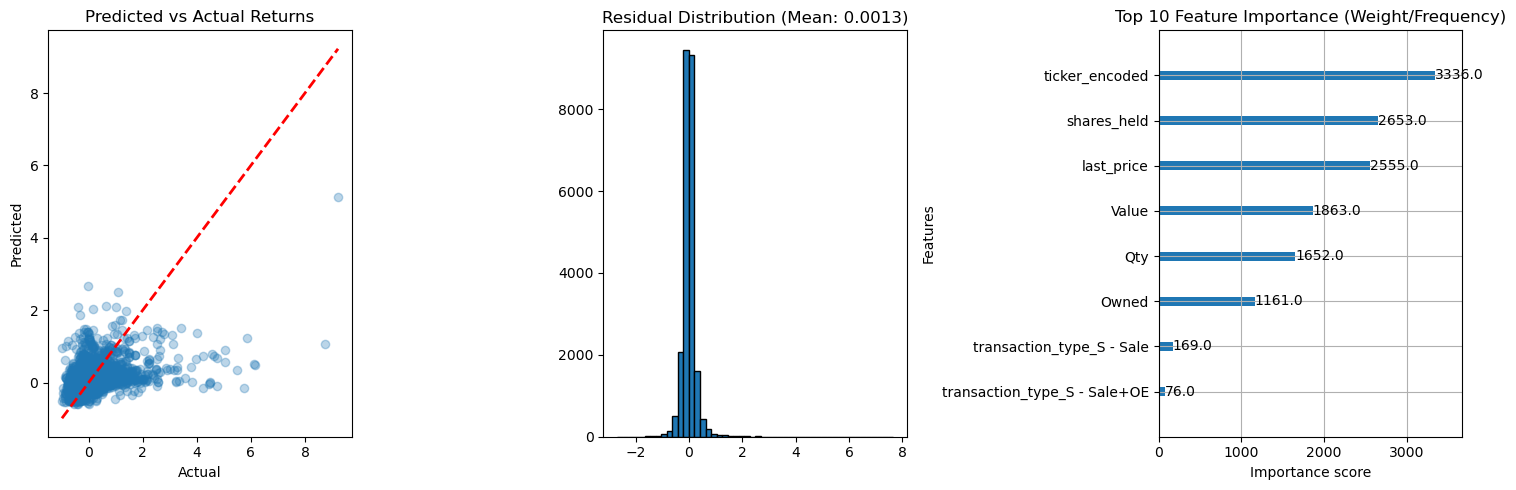


=== Overfitting Check ===
Train MAE: 0.1392
Test MAE: 0.1531
Difference: 0.0139


In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# --- Configuration ---
# NOTE: df_clean must be defined and loaded before running this script.
BASE_NUMERIC_FEATURES = ['last_price', 'Qty', 'shares_held', 'Owned', 'Value']
CATEGORICAL_FEATURES = ['transaction_type', 'ticker']
TARGET_COLUMN = 'return_60d_close'
ALL_FEATURES = BASE_NUMERIC_FEATURES + CATEGORICAL_FEATURES

# ==========================================
# 1. Data Processing Function
# ==========================================
def preprocess_splits(X_train, X_test, y_train):
    """Handles Target Encoding, One-Hot Encoding, and Scaling."""

    X_train = X_train.copy()
    X_test = X_test.copy()

    # --- A. Target Encoding for Ticker ---
    ticker_means = y_train.groupby(X_train['ticker']).mean()
    global_mean = y_train.mean()

    X_train['ticker_encoded'] = X_train['ticker'].map(ticker_means)
    X_test['ticker_encoded'] = X_test['ticker'].map(ticker_means)
    X_test['ticker_encoded'] = X_test['ticker_encoded'].fillna(global_mean)

    X_train = X_train.drop(columns=['ticker'])
    X_test = X_test.drop(columns=['ticker'])

    scaled_cols = BASE_NUMERIC_FEATURES + ['ticker_encoded']

    # --- B. One-Hot Encoding for Transaction Type ---
    X_train = pd.get_dummies(X_train, columns=['transaction_type'], drop_first=True)
    X_test = pd.get_dummies(X_test, columns=['transaction_type'], drop_first=True)

    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # --- C. Standardization (Scaling) ---
    scaler = StandardScaler()
    X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])
    X_test[scaled_cols] = scaler.transform(X_test[scaled_cols])

    return X_train, X_test

# ==========================================
# 2. Visualization Function
# ==========================================
def plot_performance(y_test, y_pred, model):
    """Generates evaluation plots including 'weight' feature importance."""

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Predicted vs Actual Returns')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    residuals = y_test - y_pred
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=50, edgecolor='black')
    plt.title(f'Residual Distribution (Mean: {residuals.mean():.4f})')

    # Plot 3: Feature Importance (Weight/Frequency)
    plt.subplot(1, 3, 3)

    xgb.plot_importance(
        model,
        max_num_features=10,
        importance_type='weight', # Changed from 'gain' to 'weight'
        ax=plt.gca()
    )
    plt.title("Top 10 Feature Importance (Weight/Frequency)")

    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN EXECUTION FLOW
# ==========================================

# Check transaction type distribution (Original Step 1)
print("Transaction Type Distribution:")
print(df_clean['transaction_type'].value_counts())

# Filter data (Original Step 1)
df_model = df_clean[df_clean[TARGET_COLUMN].abs() <= 10].copy()

# 1. Splitting Data
X = df_model[ALL_FEATURES]
y = df_model[TARGET_COLUMN]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTrain size: {len(X_train_raw)}, Test size: {len(X_test_raw)}")

# 2. Processing Data
print("\nPreprocessing data (Target Encoding and Scaling)...")
X_train, X_test = preprocess_splits(X_train_raw, X_test_raw, y_train)

# 3. Compute Sample Weights (based on raw transaction type)
weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train_raw['transaction_type']
)

# 4. Train Model
print(f"Training XGBoost on {X_train.shape[1]} features...")
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=1.0
)

# Cross-validation on training set
cv_scores = cross_val_score(model, X_train, y_train,
                             cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

model.fit(X_train, y_train, sample_weight=weights)

# 5. Evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n🚀 === Test Set Performance ===")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Baseline comparison
baseline_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
print(f"\nBaseline MAE (predicting mean): {baseline_mae:.4f}")
print(f"Improvement over baseline: {((baseline_mae - mae) / baseline_mae * 100):.2f}%")

# Performance by transaction type (using raw test data)
print("\n=== Performance by Transaction Type ===")
test_transaction_types = X_test_raw['transaction_type'].values
for trans_type in sorted(np.unique(test_transaction_types)):
    mask = test_transaction_types == trans_type
    if mask.sum() > 0:
        mae_type = mean_absolute_error(y_test[mask], y_pred[mask])
        r2_type = r2_score(y_test[mask], y_pred[mask])
        print(f"{trans_type:20s}: MAE={mae_type:.4f}, R²={r2_type:.4f}, n={mask.sum()}")


# 6. Visualize
plot_performance(y_test, y_pred, model)

# 7. Check Overfitting
train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_pred)
print(f"\n=== Overfitting Check ===")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Difference: {abs(train_mae - mae):.4f}")

# 3 MONTH

Transaction Type Distribution:
transaction_type
P - Purchase    120040
S - Sale            70
S - Sale+OE         67
Name: count, dtype: int64

Train size: 96112, Test size: 24028

Preprocessing data (Target Encoding and Scaling)...
Training XGBoost on 8 features...
Cross-validation MAE: 0.1738 (+/- 0.0018)

🚀 === Test Set Performance ===
Mean Squared Error: 0.1214
Root Mean Squared Error (RMSE): 0.3484
Mean Absolute Error (MAE): 0.1866
R² Score: 0.1493

Baseline MAE (predicting mean): 0.2006
Improvement over baseline: 6.98%

=== Performance by Transaction Type ===
P - Purchase        : MAE=0.1867, R²=0.1490, n=23995
S - Sale            : MAE=0.1158, R²=0.6954, n=18
S - Sale+OE         : MAE=0.1642, R²=0.2294, n=15


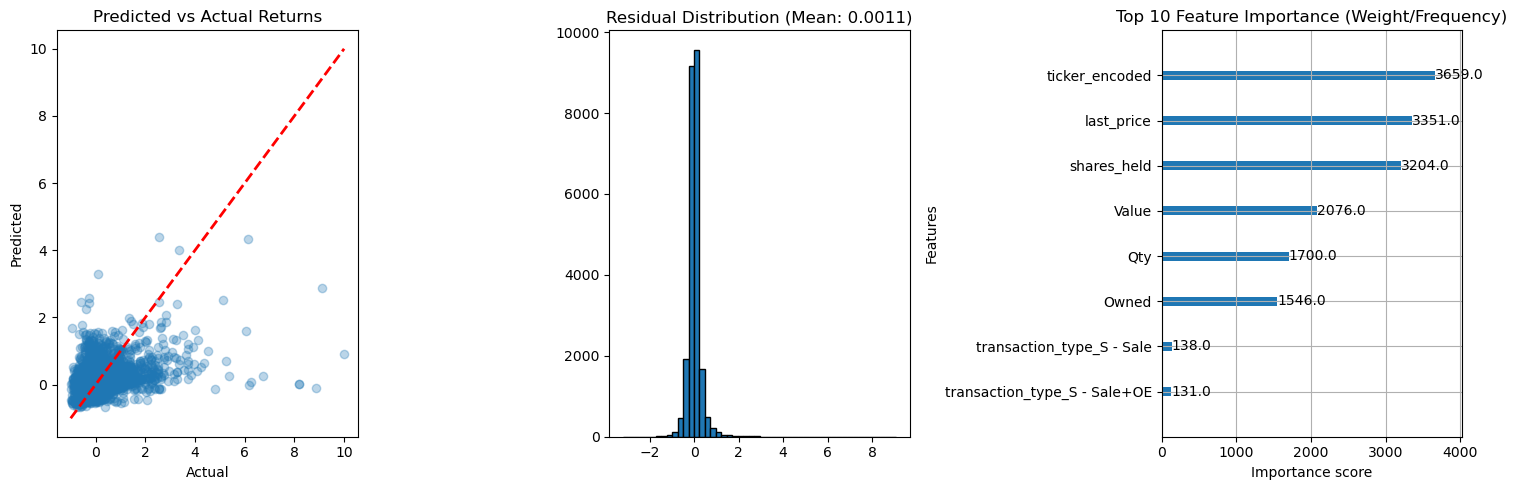


=== Overfitting Check ===
Train MAE: 0.1685
Test MAE: 0.1866
Difference: 0.0181


In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# --- Configuration ---
# NOTE: df_clean must be defined and loaded before running this script.
BASE_NUMERIC_FEATURES = ['last_price', 'Qty', 'shares_held', 'Owned', 'Value']
CATEGORICAL_FEATURES = ['transaction_type', 'ticker']
TARGET_COLUMN = 'return_90d_close'
ALL_FEATURES = BASE_NUMERIC_FEATURES + CATEGORICAL_FEATURES


# ==========================================
# 1. Data Processing Function
# ==========================================
def preprocess_splits(X_train, X_test, y_train):
    """Handles Target Encoding, One-Hot Encoding, and Scaling."""

    X_train = X_train.copy()
    X_test = X_test.copy()

    # --- A. Target Encoding for Ticker ---
    # Calculate mean return per ticker ONLY on training data
    ticker_means = y_train.groupby(X_train['ticker']).mean()
    global_mean = y_train.mean()

    X_train['ticker_encoded'] = X_train['ticker'].map(ticker_means)
    X_test['ticker_encoded'] = X_test['ticker'].map(ticker_means)

    # Fill unknown tickers in test set with the global average
    X_test['ticker_encoded'] = X_test['ticker_encoded'].fillna(global_mean)

    # Drop the original text column
    X_train = X_train.drop(columns=['ticker'])
    X_test = X_test.drop(columns=['ticker'])

    scaled_cols = BASE_NUMERIC_FEATURES + ['ticker_encoded']

    # --- B. One-Hot Encoding for Transaction Type ---
    X_train = pd.get_dummies(X_train, columns=['transaction_type'], drop_first=True)
    X_test = pd.get_dummies(X_test, columns=['transaction_type'], drop_first=True)

    # Ensure test set has same columns as train
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # --- C. Standardization (Scaling) ---
    scaler = StandardScaler()

    # Scale only the designated numeric and encoded columns
    X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])
    X_test[scaled_cols] = scaler.transform(X_test[scaled_cols])

    return X_train, X_test

# ==========================================
# 2. Visualization Function
# ==========================================
def plot_performance(y_test, y_pred, model):
    """Generates evaluation plots including 'weight' feature importance."""

    plt.figure(figsize=(15, 5))

    # Plot 1: Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.3)
    # Plot the ideal prediction line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Predicted vs Actual Returns')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Plot 2: Residual Histogram
    residuals = y_test - y_pred
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=50, edgecolor='black')
    plt.title(f'Residual Distribution (Mean: {residuals.mean():.4f})')

    # Plot 3: Feature Importance (Weight/Frequency)
    plt.subplot(1, 3, 3)

    xgb.plot_importance(
        model,
        max_num_features=10,
        importance_type='weight', # Changed from 'gain' to 'weight'
        ax=plt.gca()
    )
    plt.title("Top 10 Feature Importance (Weight/Frequency)")

    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN EXECUTION FLOW
# ==========================================

# Check transaction type distribution (Original Step 1)
print("Transaction Type Distribution:")
print(df_clean['transaction_type'].value_counts())

# Filter data (Original Step 1)
df_model = df_clean[df_clean[TARGET_COLUMN].abs() <= 10].copy()

# 1. Splitting Data
X = df_model[ALL_FEATURES]
y = df_model[TARGET_COLUMN]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTrain size: {len(X_train_raw)}, Test size: {len(X_test_raw)}")

# 2. Processing Data
print("\nPreprocessing data (Target Encoding and Scaling)...")
X_train, X_test = preprocess_splits(X_train_raw, X_test_raw, y_train)

# 3. Compute Sample Weights (based on raw transaction type)
weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train_raw['transaction_type']
)

# 4. Train Model
print(f"Training XGBoost on {X_train.shape[1]} features...")
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=1.0
)

# Cross-validation on training set
cv_scores = cross_val_score(model, X_train, y_train,
                             cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

model.fit(X_train, y_train, sample_weight=weights)

# 5. Evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n🚀 === Test Set Performance ===")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Baseline comparison
baseline_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
print(f"\nBaseline MAE (predicting mean): {baseline_mae:.4f}")
print(f"Improvement over baseline: {((baseline_mae - mae) / baseline_mae * 100):.2f}%")

# Performance by transaction type (using raw test data)
print("\n=== Performance by Transaction Type ===")
test_transaction_types = X_test_raw['transaction_type'].values
for trans_type in sorted(np.unique(test_transaction_types)):
    mask = test_transaction_types == trans_type
    if mask.sum() > 0:
        mae_type = mean_absolute_error(y_test[mask], y_pred[mask])
        r2_type = r2_score(y_test[mask], y_pred[mask])
        print(f"{trans_type:20s}: MAE={mae_type:.4f}, R²={r2_type:.4f}, n={mask.sum()}")


# 6. Visualize
plot_performance(y_test, y_pred, model)

# 7. Check Overfitting
train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_pred)
print(f"\n=== Overfitting Check ===")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Difference: {abs(train_mae - mae):.4f}")